# 🎤 Ses Verisi – Derin Öğrenme Pipeline

Bu notebook:

1. `data/` klasöründen WAV dosyalarını okur  
2. Mel spectrogram üretir  
3. Train/Test split yapar  
4. Normalizasyon uygular  
5. PyTorch DataLoader ile batch hazırlar  
6. Basit CNN modeli kurar  
7. Modeli eğitir  
8. Eğitim/doğrulama grafikleri çizer  
9. Modeli kaydeder  
10. Yeni dosya veya mikrofon ile tahmin yapar

**Tam bir Deep Learning ses sınıflandırma pipeline’ı!**


Bu Notebook şu anda:

✔ WAV’ları okur
✔ Mel spectrogram üretir
✔ Pad/trim yapar
✔ Normalizasyon yapar
✔ CNN model eğitir
✔ Grafik çizer
✔ Mikrofonla tahmin yapar
✔ Yeni dosyayı tanır


In [3]:
print("çalışıyor!")


çalışıyor!


In [4]:
# Gerekli kütüphanelerin yüklenmesi

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import librosa
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
import tempfile


print("Kütüphaneler yüklendi!")

Kütüphaneler yüklendi!


# 📥 1) Ses Dosyalarının Yüklenmesi ve Mel Spectrogram Üretimi
Bu bölüm `data/` klasöründeki tüm WAV dosyalarını okur ve her biri için sabit uzunlukta Mel spectrogram üretir.

In [7]:
# 📌 Veri klasöründen WAV dosyalarını oku ve Mel Spectrogram üret

data_path = "data"   # <-- Ses dosyalarının olduğu klasör

mel_tensor_list = []
label_list = []

max_len = 128  # Sabit Mel Spectrogram uzunluğu (frame sayısı)

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)

            # 1) Ses yükleme
            audio, sr = librosa.load(file_path, sr=16000)

            # Normalizasyon
            audio = audio / np.max(np.abs(audio))

            # 2) Mel Spectrogram
            mel = librosa.feature.melspectrogram(
                y=audio,
                sr=sr,
                n_fft=1024,
                hop_length=256,
                n_mels=64
            )

            # DB scale'e çevir
            mel_db = librosa.power_to_db(mel, ref=np.max)

            # 3) Pad / Trim — sabit boyut olsun
            if mel_db.shape[1] < max_len:
                pad_w = max_len - mel_db.shape[1]
                mel_db = np.pad(mel_db, ((0,0),(0,pad_w)), mode='constant')
            else:
                mel_db = mel_db[:, :max_len]

            # Tensöre çevir (CNN için channel=1 ekliyoruz)
            mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)
            mel_tensor_list.append(mel_tensor)

            # Etiket: klasör ismi
            label = os.path.basename(root)
            label_list.append(label)

print("Toplam dosya:", len(label_list))


Toplam dosya: 105835


# 🏷️ 2) Label’ları Sayısal Formata Çevirme
Her dosyanın sınıfı dosya adından çıkarılır (`dog_01.wav` → `dog`).


In [8]:
# 📌 String sınıfları index'e çevirme
unique_labels = list(set(label_list))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

y_idx = [label_to_idx[label] for label in label_list]

print("Sınıflar:", unique_labels)
print("Label → Index:", label_to_idx)


Sınıflar: ['bird', 'cat', 'marvin', 'four', 'left', 'two', 'down', 'sheila', 'dog', 'off', 'on', 'wow', '_background_noise_', 'backward', 'one', 'seven', 'three', 'five', 'no', 'bed', 'stop', 'zero', 'follow', 'right', 'house', 'six', 'nine', 'happy', 'tree', 'learn', 'forward', 'go', 'yes', 'up', 'eight', 'visual']
Label → Index: {'bird': 0, 'cat': 1, 'marvin': 2, 'four': 3, 'left': 4, 'two': 5, 'down': 6, 'sheila': 7, 'dog': 8, 'off': 9, 'on': 10, 'wow': 11, '_background_noise_': 12, 'backward': 13, 'one': 14, 'seven': 15, 'three': 16, 'five': 17, 'no': 18, 'bed': 19, 'stop': 20, 'zero': 21, 'follow': 22, 'right': 23, 'house': 24, 'six': 25, 'nine': 26, 'happy': 27, 'tree': 28, 'learn': 29, 'forward': 30, 'go': 31, 'yes': 32, 'up': 33, 'eight': 34, 'visual': 35}


# ✂️ 3) Train/Test Split + Normalizasyon

- Train/Test %80–%20 ayrılır  
- Normalizasyon *yalnızca train üzerinden* hesaplanır  


In [9]:
# Tüm Mel verilerini birleştir
X = torch.stack(mel_tensor_list)
y = torch.tensor(y_idx)

# 📌 Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 📌 Normalizasyon (her zaman train üzerinden)
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / (std + 1e-9)
X_test  = (X_test  - mean) / (std + 1e-9)

# 📌 DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=16)

print("Train:", len(X_train), " Test:", len(X_test))


Train: 84668  Test: 21167


# 🧠 4) Basit CNN Modelinin Tanımlanması
2× Conv → MaxPool → Fully Connected yapısı kullanılır.


In [10]:
# 📌 Basit CNN modeli

num_classes = len(unique_labels)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 64 mel → 32 → 16
        # max_len 128 → 64 → 32
        self.fc1 = nn.Linear(32 * 16 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)


# 📚 5) Modelin Eğitilmesi ve Doğrulanması
Her epoch sonunda hem train hem validation accuracy hesaplanır.


In [11]:
# 📌 Model eğitimi

num_epochs = 10
train_losses, train_accs, val_accs = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_losses.append(running_loss / total)
    train_accs.append(100 * correct / total)

    # --- Validation ---
    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            ov = model(Xv)
            _, pv = torch.max(ov, 1)
            val_total += yv.size(0)
            val_correct += (pv == yv).sum().item()

    val_accs.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {train_losses[-1]:.4f}  "
          f"Train Acc: {train_accs[-1]:.2f}%  Val Acc: {val_accs[-1]:.2f}%")


Epoch 1/10  Loss: 1.5432  Train Acc: 55.55%  Val Acc: 73.86%
Epoch 2/10  Loss: 0.7799  Train Acc: 76.85%  Val Acc: 77.57%
Epoch 3/10  Loss: 0.6212  Train Acc: 81.24%  Val Acc: 80.59%
Epoch 4/10  Loss: 0.5313  Train Acc: 83.88%  Val Acc: 82.62%
Epoch 5/10  Loss: 0.4664  Train Acc: 85.75%  Val Acc: 82.74%
Epoch 6/10  Loss: 0.4218  Train Acc: 87.04%  Val Acc: 82.50%
Epoch 7/10  Loss: 0.3824  Train Acc: 88.15%  Val Acc: 83.83%
Epoch 8/10  Loss: 0.3493  Train Acc: 89.15%  Val Acc: 83.79%
Epoch 9/10  Loss: 0.3207  Train Acc: 90.08%  Val Acc: 84.18%
Epoch 10/10  Loss: 0.2975  Train Acc: 90.64%  Val Acc: 84.25%


# 📊 6) Eğitim Grafikleri


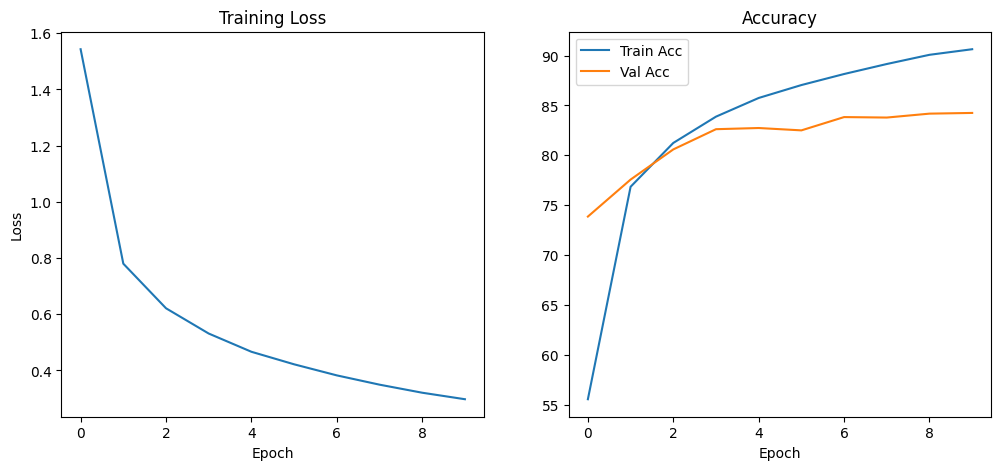

In [12]:
# 📌 Kayıp ve doğruluk grafiklerinin çizilmesi

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()


# 💾 7) Modeli Kaydetme


In [13]:
torch.save(model.state_dict(), "simple_cnn_model.pth")
print("Model kaydedildi!")


Model kaydedildi!


# 🔮 8) Yeni Ses Dosyasından Tahmin Fonksiyonu


In [14]:
# 📌 Yeni bir ses dosyası için tahmin fonksiyonu

def predict_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    audio = audio / np.max(np.abs(audio))

    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=1024, hop_length=256, n_mels=64
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        mel_db = np.pad(mel_db, ((0,0),(0,max_len - mel_db.shape[1])), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    mel_tensor = torch.tensor(mel_db).unsqueeze(0).unsqueeze(0)
    mel_tensor = (mel_tensor - mean) / (std + 1e-9)
    mel_tensor = mel_tensor.float().to(device)

    model.eval()
    with torch.no_grad():
        output = model(mel_tensor)
        _, pred = torch.max(output, 1)

    return unique_labels[pred.item()]


# 🎙️ 9) Mikrofon ile Canlı Tahmin
Mikrofonla 2 saniyelik kayıt alır ve model tahmin eder.


In [63]:
# 📌 Mikrofon ile ses kaydedip tahmin yapma

duration = 2    # saniye
sr = 16000

with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
    print("Konuşun (2 saniye)...")
    recording = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()

    # Tek boyutlu hale getir ve float32 tipi uygula
    recording = recording.flatten().astype('float32')

    sf.write(tmp.name, recording, sr)

    label = predict_audio(tmp.name)
    print("Tahmin edilen sınıf:", label)


Konuşun (2 saniye)...
Tahmin edilen sınıf: right
